# Create session

In [1]:
from pybit import usdt_perpetual
from pybit.exceptions import InvalidRequestError

# endpoint = 'https://api.bybit.com'
endpoint = 'https://api-testnet.bybit.com'
api_key = '36JsmrW074AFy8ehcI'
api_secret = 'U7gXUg3hCR5g4b7k2NALxuroDbRzJmA4fajP'

session = usdt_perpetual.HTTP(
                              endpoint, 
                              api_key=api_key, 
                              api_secret=api_secret
                             )

# Set isolated/cross margin function

In [2]:
def set_margin(symbol, is_isolated, buy_leverage, sell_leverage) -> bool:
    try:
        session.cross_isolated_margin_switch(
            symbol=symbol,
            is_isolated=is_isolated,
            buy_leverage=buy_leverage,
            sell_leverage=sell_leverage
        )
    except InvalidRequestError:
        print(f'Isolated margin mode is already set at {is_isolated} value')
        return False
    return True

# Set leverage function

In [3]:
def set_leverage(symbol, buy_leverage, sell_leverage) -> bool:
    try:
        session.set_leverage(
            symbol=symbol,
            buy_leverage=buy_leverage,
            sell_leverage=sell_leverage
        )
    except InvalidRequestError:
        print(f'Buy/sell leverages are already set at {buy_leverage}/{sell_leverage} values')
        return False
    return True

# Place position function

In [36]:
def place_order(symbol, ttype, otype, price, quantity, stop_loss, take_profit, time_in_force):
    session.place_active_order(
                                symbol=symbol,
                                side=ttype,
                                order_type=otype,
                                qty=quantity,
                                price=price,
                                time_in_force=time_in_force,
                                reduce_only=False,
                                close_on_trigger=False,
                                stop_loss=stop_loss,
                                take_profit=take_profit,
                                position_idx=0
                                )
    return True

# Open position

In [38]:
round_symbols = 10

coin='USDT'
symbol = 'CRVUSDT'

is_isolated = True

buy_leverage = 5
sell_leverage = 5

ttype = 'Buy'
otype = 'Limit'
time_in_force = 'GoodTillCancel'

risk = 0.01
price =  0.42

stop_loss = 0.4
take_profit = 0.45

balance = session.get_wallet_balance(coin=coin) 
free = r['result'][coin]['available_balance']
quantity = ((free * risk) / price)
quantity = float(str(quantity)[:round_symbols])
print(quantity)

set_margin(symbol, is_isolated, buy_leverage, sell_leverage)
set_leverage(symbol, buy_leverage, sell_leverage)
place_order(symbol, ttype, otype, price, quantity, stop_loss, take_profit, time_in_force)

237.512992
Buy/sell leverages are already set at 5/5 values


True

# Create test dataframe

In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from datetime import datetime
from os import environ
from data.get_data import GetData
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory
from signals.find_signal import SignalFactory

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)

debug = False
# Set environment variable
environ["ENV"] = "test"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}

# Get configs
configs = ConfigFactory.factory(environ).configs
       
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'API': GetData(**configs), 'tickers': ['CRVUSDT']}}

# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange, **configs)
    tickers = exchanges[exchange]['tickers']
    exchange_api.fill_ticker_dict(tickers)
    exchanges[exchange]['API'] = exchange_api

    # Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_data in exchanges.items():
    exchange_api = exchange_data['API']
    tickers = exchange_data['tickers']
    timeframes = ['1h', '5m']
    for ticker in tickers:
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, data_qty = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if data_qty > 1:
                indicators = list()
                points = dict()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['SUP_RES', 'LinearReg']
                for ttype in ['buy', 'sell']:
                    for indicator in indicator_list:
                        ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
                        if ind_factory:
                            indicators.append(ind_factory)
                    # Write indicators to dataframe, update dataframe dict
                    dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)
                    # Get signals
                    if timeframe == work_timeframe:
                        fs = FindSignal(ttype, configs)
                        points[ttype] = fs.find_signal(dfs, ticker, timeframe, data_qty)

Exchange is Binance, ticker is CRVUSDT, timeframe is 1h
Exchange is Binance, ticker is CRVUSDT, timeframe is 5m


# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

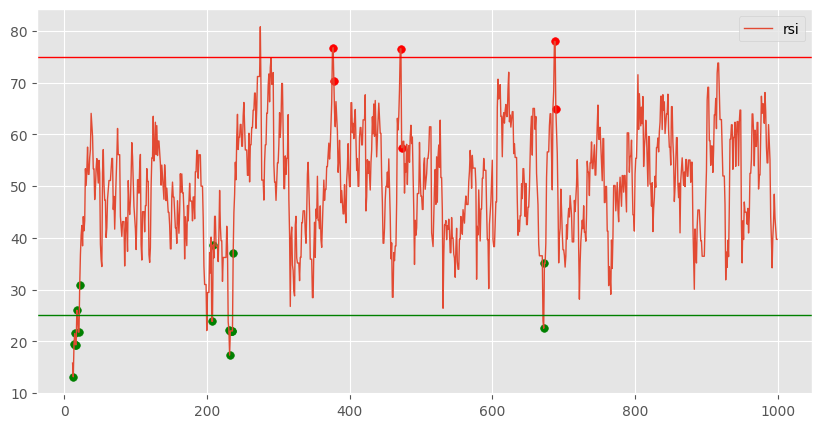

In [4]:
high_bound = 75
low_bound = 25
ttype = 'buy'

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', ttype, configs)

rsi_idxs =  rsi_sig.lower_bound(low_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_buy_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_buy_rsi_points.index, scatter_buy_rsi_points.values, s=30, color='green')

rsi_idxs =  rsi_sig.higher_bound(high_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_sell_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_sell_rsi_points.index, scatter_sell_rsi_points.values, s=30, color='red')
    
plt.show()

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

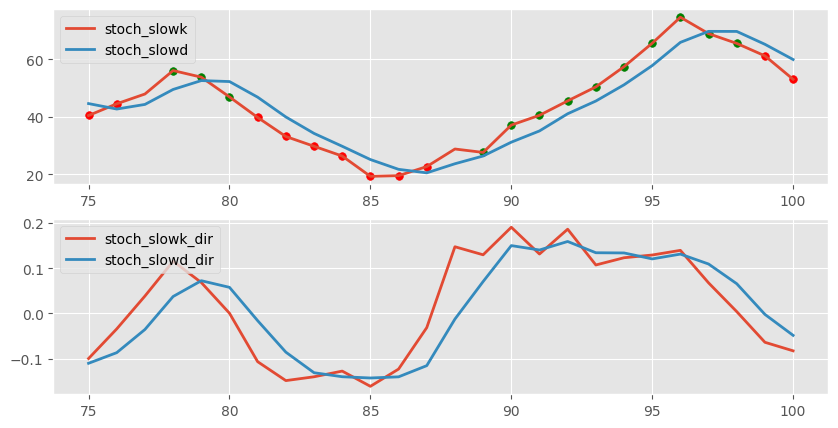

In [34]:
ttype = 'buy'

# subplots for STOCH
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[75:100, 'stoch_slowk'], linewidth=2)
ax1.plot(df.loc[75:100, 'stoch_slowd'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowk_dir'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowd_dir'], linewidth=2)
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()

stoch_sig = SignalFactory().factory('STOCH', ttype, configs)

scatter_stoch_points_up = stoch_sig.up_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                          stoch_sig.up_direction(df.loc[75:100, 'stoch_slowd_dir'])
scatter_stoch_points_down = stoch_sig.down_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                            stoch_sig.down_direction(df.loc[75:100, 'stoch_slowd_dir'])

ax1.scatter(np.where(scatter_stoch_points_up)[0] + 75, df.loc[np.where(scatter_stoch_points_up)[0] + 75, 'stoch_slowk'], 
            s=30, color='green')
ax1.scatter(np.where(scatter_stoch_points_down)[0] + 75, df.loc[np.where(scatter_stoch_points_down)[0] + 75, 'stoch_slowk'], 
            s=30, color='red')
    
plt.show()

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

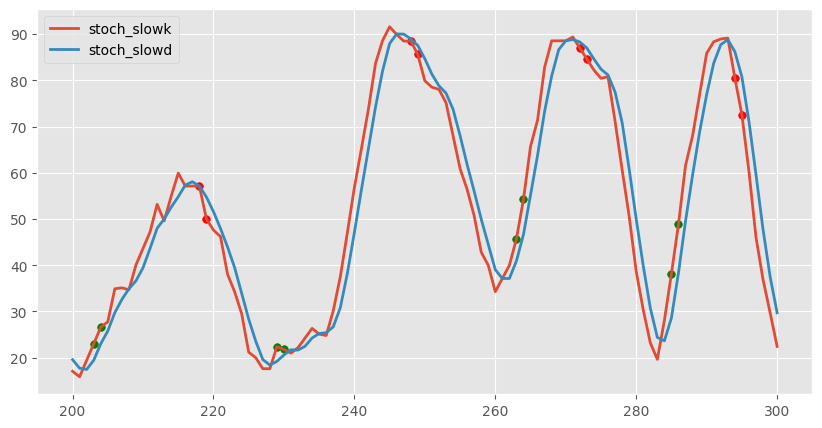

In [46]:
# subplots for RSI
ttype = 'sell'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ax.plot(df.loc[200:300, 'stoch_slowk'], linewidth=2)
ax.plot(df.loc[200:300, 'stoch_slowd'], linewidth=2)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
stoch_sig = SignalFactory().factory('STOCH', ttype, configs)
scatter_stoch_points_up = stoch_sig.crossed_lines(False, df.loc[200:300, 'stoch_diff'], 
                                                  df.loc[200:300, 'stoch_diff'].shift(1), 
                                                  df.loc[200:300, 'stoch_diff'].shift(2)) 
scatter_stoch_points_down = stoch_sig.crossed_lines(True, df.loc[200:300, 'stoch_diff'], 
                                                    df.loc[200:300, 'stoch_diff'].shift(1), 
                                                    df.loc[200:300, 'stoch_diff'].shift(2)) 

ax.scatter(np.where(scatter_stoch_points_up)[0] + 200, df.loc[np.where(scatter_stoch_points_up)[0] + 200, 
                                                              'stoch_slowk'], s=30, color='green')
ax.scatter(np.where(scatter_stoch_points_down)[0] + 200, df.loc[np.where(scatter_stoch_points_down)[0] + 200, 
                                                                'stoch_slowk'], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

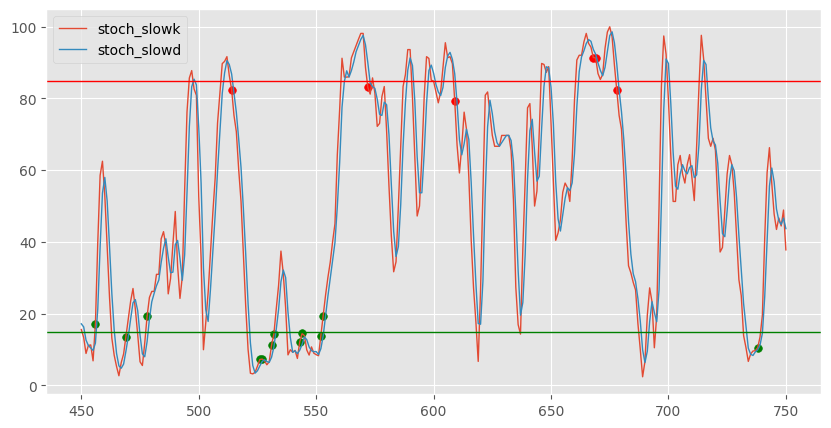

In [15]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
high_bound = 85
low_bound = 15
ax.plot(df.loc[450:750, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[450:750, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 450 < index < 750:
        fs = stoch_sig.find_signal(df, index)
        if fs[0]:
            if fs[1] == 'buy':
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            else:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for MACD indicator

This methods return True if macd and macdsignal lines has crossed and both changed their direction.

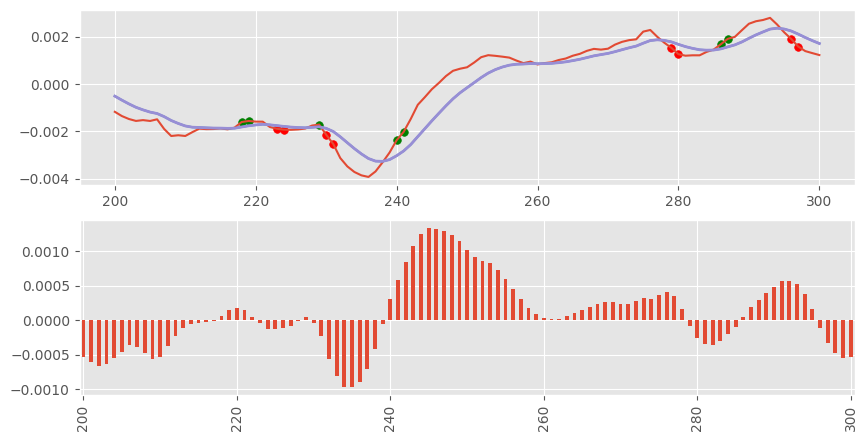

In [158]:
# subplots for MACD
ttype = 'sell'
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot MACD
df.loc[200:300, 'macd'].plot(ax=ax[0])
df.loc[200:300, 'macdsignal'].plot(ax=ax[0])
ax[0].plot(df.loc[200:300, 'macdsignal'], linewidth=2)
ax[0].set_xticks(np.arange(200, 301, 20))
ax[0].set_xticklabels(np.arange(200, 320, 20))

df.loc[200:300, 'macdhist'].plot.bar(ax=ax[1])
ax[1].set_xticks(ax[0].get_xticks()-200)

# plot signal points
stoch_sig = SignalFactory().factory('STOCH', ttype, configs)
scatter_stoch_points_up = stoch_sig.crossed_lines(False, df.loc[200:300, 'macdhist'], 
                                                  df.loc[200:300, 'macdhist'].shift(1), 
                                                  df.loc[200:300, 'macdhist'].shift(2)) 
scatter_stoch_points_down = stoch_sig.crossed_lines(True, df.loc[200:300, 'macdhist'], 
                                                    df.loc[200:300, 'macdhist'].shift(1), 
                                                    df.loc[200:300, 'macdhist'].shift(2)) 

ax[0].scatter(np.where(scatter_stoch_points_up)[0] + 200, df.loc[np.where(scatter_stoch_points_up)[0] + 200, 
                                                                 'macd'], s=30, color='green')
ax[0].scatter(np.where(scatter_stoch_points_down)[0] + 200, df.loc[np.where(scatter_stoch_points_down)[0] + 200, 
                                                                   'macd'], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for MACD indicator

This methods return True if macd and macdsignal lines has crossed and both changed their direction.

In [ ]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ttype = 'buy'
ax.plot(df.loc[450:750, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[450:750, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 450 < index < 750:
        fs = stoch_sig.find_signal(df, index)
        if fs[0]:
            if fs[1] == 'buy':
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            else:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test find_lr method for LR indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

In [22]:
import pandas as pd
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE
timeperiod = 72

df_btc_1h = pd.read_pickle('test_ETHUSDT_1h.pkl')
df_btc_1h['linear_reg'] = LINEARREG(df_btc_1h['close'], timeperiod).reset_index(drop=True)
df_btc_1h['linear_reg_angle'] = LINEARREG_ANGLE(df_btc_1h['close'], timeperiod).reset_index(drop=True)

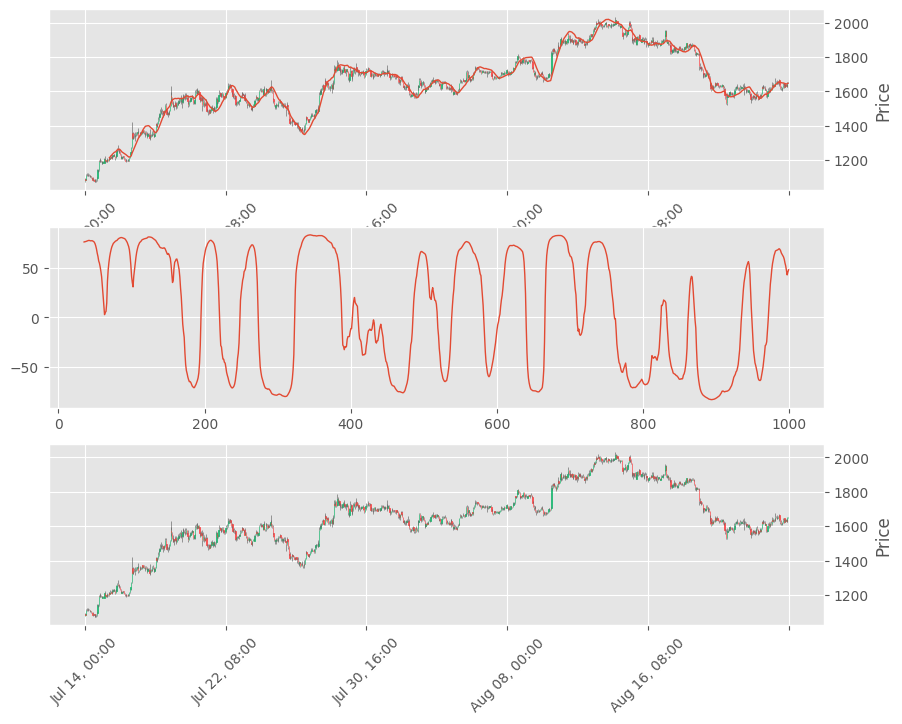

In [26]:
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE

low_bound = 0
high_bound = 1000
timeperiod = 36

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
dfm = pd.read_pickle('test_ETHUSDT_1h.pkl')
dfh = pd.read_pickle('test_ETHUSDT_1h.pkl')

# subplots for RSI
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# plot candles
ohlch = dfh.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=axs[0], warn_too_much_data=10000, style='yahoo')

lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)

axs[0].plot(lr, linewidth=1)
axs[1].plot(lr_angle, linewidth=1)

ohlcm = dfm.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlcm = ohlcm.set_index('time')
mpf.plot(ohlcm, type='candle', ax=axs[2], warn_too_much_data=10000, style='yahoo')
        
# plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI))

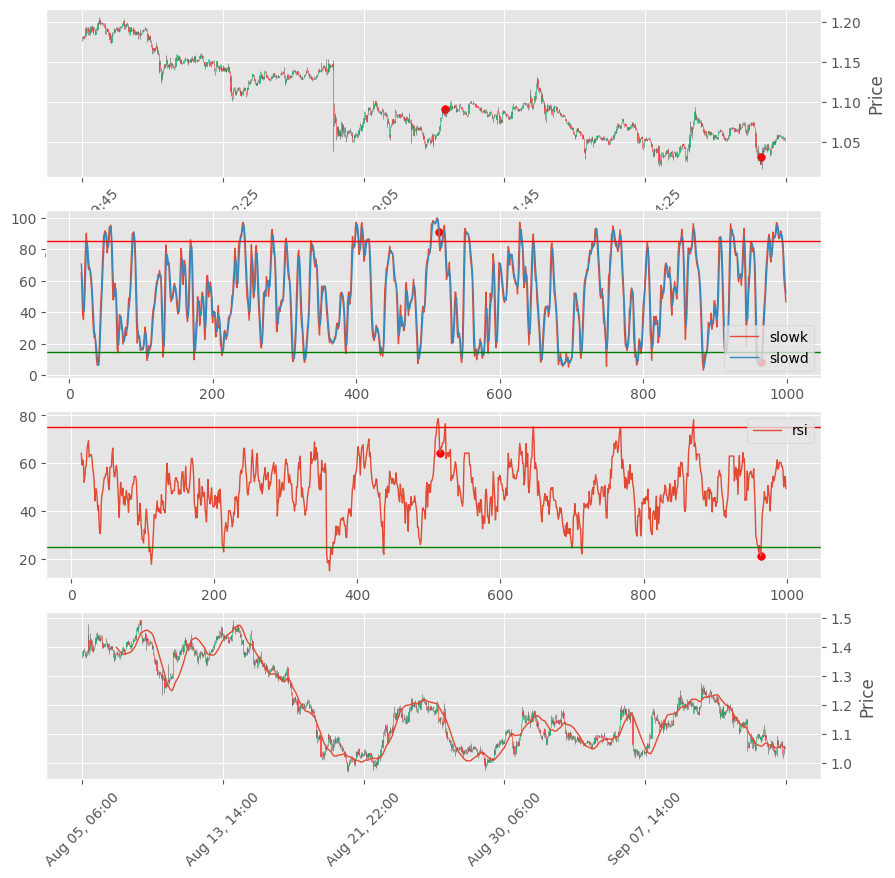

In [43]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
dfm = dfs['CRVUSDT']['5m']['data']
dfh = dfs['CRVUSDT']['1h']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(dfs, 'CRVUSDT', '5m', data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

# plot candles
ohlc = dfm.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(dfm.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

        
# plot higher timeframe candles + trend
ohlch = dfh[['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=ax4, warn_too_much_data=10000, style='yahoo')

timeperiod = 50
lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)
ax4.plot(lr, linewidth=1)

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], dfm.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], dfm.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], dfm.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], dfm.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

In [39]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

TypeError: FindSignal.find_signal() takes 5 positional arguments but 6 were given